# Clustering of genomic bins

Cluster based on:
- DamID LMNB1:
 - zygote - heterozygous
 - 2-cell - heterozygous
 - 8-cell - heterozygous
 - mESC - heterozygous
- H3K27me3
 - zygote - heterozygous
 - 2-cell - heterozygous
 - 8-cell - heterozygous
 - mECS - homozygous

Bin size 100kb

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/5.2_Preimplantation.simplified_bin_clustering.part1.Performing_clustering.allelic_bias_correction/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.treatment.isin(['no_treatment'])]
anno = anno.set_index('damid_name')
anno = anno[anno.DamID_PASS]

In [8]:
anno.groupby(['stage', 'genotype', 'treatment']).size()

stage   genotype                treatment   
2cell   CBAB6F1_x_CAST/EiJ      no_treatment     27
        homozygous              no_treatment    218
8cell   CBAB6F1_x_CAST/EiJ      no_treatment     21
        homozygous              no_treatment    212
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment    268
zygote  CBAB6F1_x_CAST/EiJ      no_treatment     14
        homozygous              no_treatment    107
dtype: int64

__Generate a samplesheet for in silico populations__

In [9]:
anno_comb = anno[anno.DamID_PASS].groupby(['stage', 'fusion_construct', 'genotype', 'treatment', 'is_heterozygous']).size().reset_index().drop(columns=[0])
anno_comb['stage'] = pd.Categorical(anno_comb['stage'], categories=['zygote', '2cell', '8cell', 'morula', 'early_blastocyst', 'mESC'])
anno_comb['is_singlecell'] = True
anno_comb.loc[anno_comb.stage.isin(['morula', 'early_blastocyst']), 'is_singlecell'] = False
anno_comb = anno_comb.sort_values(by=['stage', 'is_heterozygous', 'genotype', 'treatment'])

## 1.2 Loading mappability

In [10]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [11]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [12]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__Contact Frequency__

In [13]:
contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
    name = (info[1], info[2], info[3])
    
    if len(glob(fn)) == 0:
        print('CF does not exist for', info)
        continue
        
    contact_freq['combined'][name] =  load_count_file(fn)
    
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
            contact_freq[parent][name] =  load_count_file(fn)

## 1.4 Loading allele visibility

In [14]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 2. Loading external data sets

In [15]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment == 'no']
ext_anno = ext_anno[~ext_anno.target.isin(['H3', 'H3K27ac'])]

select_stages = [
    'PN3_zygote', 'PN5_zygote', 
    '2cell', '2cell_late', '8cell',
    'mESC'
]

ext_anno = ext_anno[ext_anno.stage.isin(select_stages)]
ext_anno['stage'] = pd.Categorical(ext_anno['stage'], select_stages)

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [16]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: D[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: D[c][:len(mapab[c])] for c in chrom_order}

In [17]:
ext_anno[(ext_anno.target=='H3K4me3') & (ext_anno.stage=='mESC')]

sample_id technique stage   target treatment  is_heterozygous  \
46         GSE71434_018  ChIP-seq  mESC  H3K4me3        no            False   
47         GSE71434_019  ChIP-seq  mESC  H3K4me3        no            False   
74         GSE73952_023  ChIP-seq  mESC  H3K4me3        no            False   
112        GSE97778_014  ChIP-seq  mESC  H3K4me3        no            False   
127  EncodeHardison_003  ChIP-seq  mESC  H3K4me3        no            False   

      genotype genotype_maternal genotype_paternal       dataset_id  \
46          R1               NaN               NaN         GSE71434   
47          R1               NaN               NaN         GSE71434   
74      B6D2F1               NaN               NaN         GSE73952   
112         R1               NaN               NaN         GSE97778   
127  E14TG2a.4               NaN               NaN  Encode_Hardison   

             control_id replicate library_layout read_length_bp  
46                 none      rep1  PAIRED;SINGLE     202;51;252  
47                 none      rep1         SINGLE             51  
74         GSE73952_022     rep12         SINGLE             71  
112                none     rep12         PAIRED            300  
127  EncodeHardison_004      rep1         SINGLE             45

In [18]:
ext_anno[ext_anno.target=='H3K27me3']

sample_id technique       stage    target treatment  \
59         GSE73952_008  ChIP-seq       2cell  H3K27me3        no   
65         GSE73952_014  ChIP-seq       8cell  H3K27me3        no   
75         GSE73952_024  ChIP-seq        mESC  H3K27me3        no   
86         GSE76687_006  ChIP-seq  PN5_zygote  H3K27me3        no   
88         GSE76687_008  ChIP-seq  2cell_late  H3K27me3        no   
89         GSE76687_009  ChIP-seq       8cell  H3K27me3        no   
97         GSE76687_018  ChIP-seq        mESC  H3K27me3        no   
98         GSE76687_019  ChIP-seq  2cell_late  H3K27me3        no   
104        GSE97778_006  ChIP-seq  PN3_zygote  H3K27me3        no   
113        GSE97778_015  ChIP-seq        mESC  H3K27me3        no   
126  EncodeHardison_002  ChIP-seq        mESC  H3K27me3        no   

     is_heterozygous        genotype genotype_maternal genotype_paternal  \
59             False          B6D2F1               NaN               NaN   
65             False          B6D2F1               NaN               NaN   
75             False          B6D2F1               NaN               NaN   
86              True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
88              True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
89              True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
97             False              R1               NaN               NaN   
98              True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
104            False          B6D2F1               NaN               NaN   
113            False              R1               NaN               NaN   
126            False       E14TG2a.4               NaN               NaN   

          dataset_id          control_id replicate library_layout  \
59          GSE73952        GSE73952_006    rep123         PAIRED   
65          GSE73952        GSE73952_012    rep123         PAIRED   
75          GSE73952        GSE73952_022   rep1234         SINGLE   
86          GSE76687                none     rep12  PAIRED;SINGLE   
88          GSE76687                none     rep12         PAIRED   
89          GSE76687                none      rep1         PAIRED   
97          GSE76687                none      rep1         SINGLE   
98          GSE76687                none      rep1         SINGLE   
104         GSE97778        GSE97778_004    rep123         PAIRED   
113         GSE97778                none     rep12         PAIRED   
126  Encode_Hardison  EncodeHardison_004      rep1         SINGLE   

      read_length_bp  
59               250  
65           250;300  
75                71  
86   101;252;202;252  
88           202;252  
89               252  
97                51  
98    51;101;202;252  
104              250  
113              300  
126               45

## 2.1 Select data that will be used for clustering

In [19]:
ext_cluster_samples = [
    'GSE76687_006', # H3K27me3 - PN5 zygote - hybrid - no control
    'GSE76687_008', # H3K27me3 - 2cell (late) - hybrid - no control
    'GSE76687_009', # H3K27me3 - 8cell - hybrid - no control
    'GSE76687_018', # H3K27me3 - mESC - homozygous - no control
]

# 3. Dimensionality reduction

## 3.1 Selecting the relevant samples

__Select external data__

In [20]:
ext_cluster_anno = ext_anno[ext_anno.sample_id.isin(ext_cluster_samples)].copy()

# use allelic data when available, except for the H3K9me3 cross because it has poor allelic separation
ext_cluster_anno['use_allelic'] = ext_cluster_anno.is_heterozygous
ext_cluster_anno.loc[ext_cluster_anno.genotype == "C57BL/6_x_DB/2", 'use_allelic'] = False

ext_cluster_anno

sample_id technique       stage    target treatment  is_heterozygous  \
86  GSE76687_006  ChIP-seq  PN5_zygote  H3K27me3        no             True   
88  GSE76687_008  ChIP-seq  2cell_late  H3K27me3        no             True   
89  GSE76687_009  ChIP-seq       8cell  H3K27me3        no             True   
97  GSE76687_018  ChIP-seq        mESC  H3K27me3        no            False   

          genotype genotype_maternal genotype_paternal dataset_id control_id  \
86  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   GSE76687       none   
88  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   GSE76687       none   
89  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   GSE76687       none   
97              R1               NaN               NaN   GSE76687       none   

   replicate library_layout   read_length_bp  use_allelic  
86     rep12  PAIRED;SINGLE  101;252;202;252         True  
88     rep12         PAIRED          202;252         True  
89      rep1         PAIRED              252         True  
97      rep1         SINGLE               51        False

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_34987/3194074615.py:37: RuntimeWarning: invalid value encountered in true_divide
  Y2 = Y / Yav


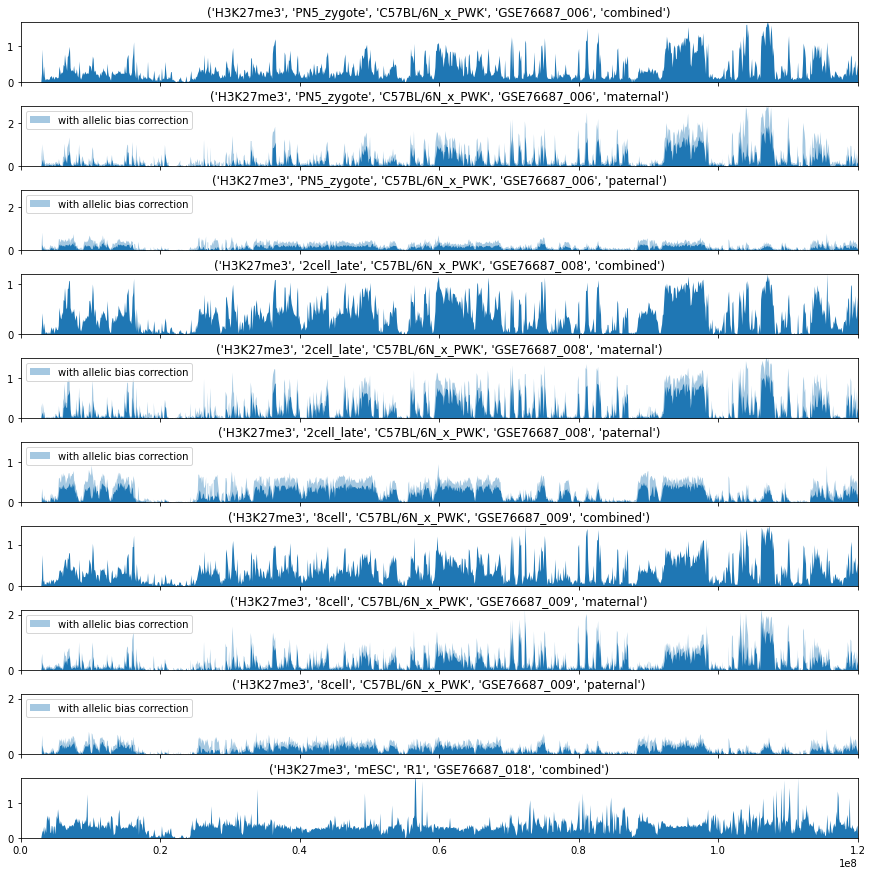

In [21]:
to_plot = ext_cluster_anno.copy()
to_plot = to_plot.sort_values(by=['target', 'stage'])

clrdict = {t: sns.color_palette('tab10', n_colors=10)[i] for i, t in enumerate(to_plot.target.unique())}

nrow = len(to_plot) + to_plot.use_allelic.sum()*2
fig, axes = plt.subplots(nrow, 1, figsize=(15,nrow*1.5), sharex=True)
plt.subplots_adjust(hspace=.4)
counter = 0

chrom = '12'

for _, row in to_plot.iterrows():
    
    parents = ['combined', 'maternal', 'paternal'] if row['use_allelic'] else ['combined']
    
    for parent in parents:
    
        Y = ext_data[parent][row['sample_id']][chrom]
        X = np.arange(0, len(Y)*BINSIZE, BINSIZE)

        ax = axes[counter]
        counter += 1

        ax.set_title((row['target'], row['stage'], row['genotype'], row['sample_id'], parent))


        if row['control_id'] != 'none':
            Yc = ext_data['combined'][row['control_id']][chrom]
            Yoe = np.log2( (Y + .1) / (Yc + .1) )
            ax.fill_between(X, 0, Yoe, color=clrdict[row['target']], lw=0)
        else:
            ax.fill_between(X, 0, Y, color=clrdict[row['target']], lw=0)
            
            if parent != 'combined':
                Yav = ext_data['allele_vis'][row['sample_id']][chrom]
                Y2 = Y / Yav
                Y2[Yav < .1] = np.nan
#                 ax.plot(X, Y2, c='k')
                ax.fill_between(X, 0, Y2, color=clrdict[row['target']], lw=0, alpha=.4, label='with allelic bias correction')
                ax.legend(loc=('upper left'))
                ax.set_ylim(0, np.nanpercentile(Y2, 99.9))
            else:
                ax.set_ylim(0, np.nanpercentile(Y, 99.9))
                
        if parent == 'paternal':
            ylim_m = axes[counter-2].get_ylim()
            ylim_p = ax.get_ylim()
            ylim = (min(ylim_m[0], ylim_p[0]), max(ylim_m[1], ylim_p[1]))
            axes[counter-2].set_ylim(ylim)
            ax.set_ylim(ylim)
                

        ax.set_xlim(0, X[-1])
    

__Select DamID data__

In [22]:
anno_damid_cluster = anno_comb.copy()

ind0 = anno_damid_cluster.is_heterozygous # only use het samples
ind1 = anno_damid_cluster.stage.isin(['zygote', '2cell', '8cell', 'mESC']) # use only these stages
ind2 = anno_damid_cluster.treatment == 'no_treatment'
anno_damid_cluster = anno_damid_cluster[ind0 & ind1 & ind2]

anno_damid_cluster

stage fusion_construct                genotype     treatment  \
5  zygote        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ  no_treatment   
0   2cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ  no_treatment   
2   8cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ  no_treatment   
4    mESC        Dam-Lmnb1  129S1/SvImJ_x_CAST/EiJ  no_treatment   

   is_heterozygous  is_singlecell  
5             True           True  
0             True           True  
2             True           True  
4             True           True

__Select chromsomes to cluster over: exclude X & Y__

In [23]:
cluster_chroms = np.array([str(c) for c in range(1,20)])
cluster_chroms

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'], dtype='<U2')

## 3.2 Determine which bins should be filtered out of the analysis

In [24]:
filter_dict = dict()

filter_dict['GATC_mapab'] = {c: mapab[c] > MINMAP for c in cluster_chroms}
filter_dict['embryo_split'] = {c: allele_filt_gt['CBAB6F1_x_CAST/EiJ'][c] for c in cluster_chroms}
filter_dict['mESC_split'] = {c: allele_filt_gt['129S1/SvImJ_x_CAST/EiJ'][c] for c in cluster_chroms}

for _, row in ext_cluster_anno[ext_cluster_anno.use_allelic].iterrows():
    sample = row['sample_id']
    name = '%s_%s' % (row['stage'], row['target'])
    
    v = {c: ext_data['allele_vis'][sample][c] > .1 for c in cluster_chroms}
    filter_dict[name] = v

filter_dict['ENCODE_bl'] = {c: (~ext_data['blacklisted'][c]) for c in cluster_chroms}

    
cluster_filt_ind = {c: np.ones(len(mapab[c])).astype(bool) for c in cluster_chroms}

for key in filter_dict:
    
    F1 = np.concatenate([filter_dict[key][c] for c in cluster_chroms])
    
    cluster_filt_ind = {c: cluster_filt_ind[c] & filter_dict[key][c] for c in cluster_chroms}
    
    F0 = np.concatenate([cluster_filt_ind[c] for c in cluster_chroms])
    
    print('%s: filters %.1f; new filter total: %.1f' % (key, F1.mean()*100, F0.mean()*100))
    


GATC_mapab: filters 96.5; new filter total: 96.5
embryo_split: filters 94.5; new filter total: 94.2
mESC_split: filters 93.4; new filter total: 92.9
PN5_zygote_H3K27me3: filters 92.7; new filter total: 89.0
2cell_late_H3K27me3: filters 93.4; new filter total: 88.8
8cell_H3K27me3: filters 93.1; new filter total: 88.3
ENCODE_bl: filters 97.0; new filter total: 88.2


## 3.3 Combining data & standardize

In [25]:
from collections import defaultdict

In [26]:
cluster_data = dict()
cluster_anno = defaultdict(list)

# external data
for _, row in ext_cluster_anno.iterrows():
    
    sample = row['sample_id']
    control = row['control_id']
    
    parents = ['maternal', 'paternal'] if row['use_allelic'] else ['combined']
    
    for parent in parents:
        
        # get data
        D = np.concatenate([ext_data[parent][sample][c][cluster_filt_ind[c]] for c in cluster_chroms])
        
        # perform normalization for control if available
        if control != 'none':
            C = np.concatenate([ext_data[parent][control][c][cluster_filt_ind[c]] for c in cluster_chroms])
            D = np.log2( (D + 0.1) / (C + 0.1) )
        else:
            
            # if no control is available for allelic data, perform an "allele visibility" correction
            if parent != 'combined':
                av = np.concatenate([ext_data['allele_vis'][sample][c][cluster_filt_ind[c]] for c in cluster_chroms])
                D = D / av
            
            D = np.log10( D + 0.1 )
            
        # standardize data
        m = D.mean()
        s = np.std(D)
        Dz = (D - m) /s
        
        N = '%s_%s' % (sample, parent)
        cluster_data[N] = Dz
        
        # add to general sample sheet
        cluster_anno['name'].append(N)
        cluster_anno['stage'].append(row['stage'])
        cluster_anno['target'].append(row['target'])
        cluster_anno['parent'].append(parent)
        
# damid data
assert len(anno_damid_cluster.stage.unique()) == len(anno_damid_cluster)
for _, row in anno_damid_cluster.iterrows():
    stage = row['stage']
    sample = (row['stage'], row['genotype'], row['treatment'])
    
    for parent in ['maternal', 'paternal']:
        D = np.concatenate([contact_freq[parent][sample][c][cluster_filt_ind[c]] for c in cluster_chroms])
        
        # standardize data
        m = D.mean()
        s = np.std(D)
        Dz = (D - m) /s
        
        N = '%s_%s' % (stage, parent)
        cluster_data[N] = Dz
        
        # add to general sample sheet
        cluster_anno['name'].append(N)
        cluster_anno['stage'].append(row['stage'])
        cluster_anno['target'].append('Lmnb1')
        cluster_anno['parent'].append(parent)
        
cluster_data = pd.DataFrame(cluster_data)
cluster_anno = pd.DataFrame(cluster_anno)
cluster_anno['stage'] = pd.Categorical(
    cluster_anno['stage'], 
    categories=['PN5_zygote', 'zygote', '2cell', '2cell_late', '8cell', 'mESC']
)

### Clip data to range (-2.5,2.5)

In [27]:
## CLIP Z-SCORES TO AVOID EXTREME OUTLIERS
cluster_data = cluster_data.clip(-2.5,2.5)

### Inspect standardized data

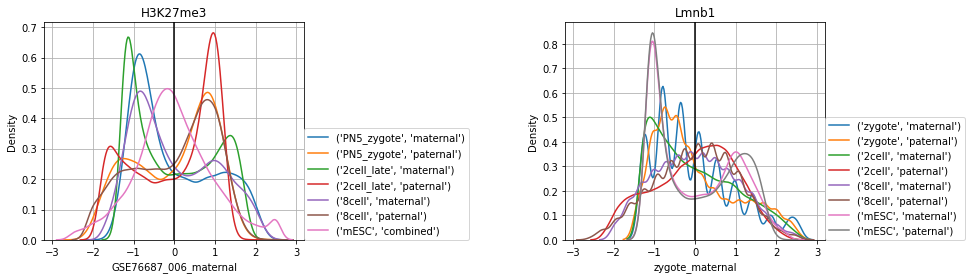

In [28]:
g_to_plot = cluster_anno.groupby('target')
nplot = len(list(g_to_plot))
ncol = 2
nrow = int(np.ceil(nplot/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*7, nrow*4), sharex=True)
plt.subplots_adjust(hspace=.4, wspace=1)
counter = 0

for target, df in g_to_plot:
    ax = axes.flatten()[counter]
    counter += 1
    
    ax.set_title(target)
    
    for _, row in df.iterrows():
        sns.kdeplot(cluster_data[row['name']], label=(row['stage'], row['parent']), ax=ax)
    
    ax.legend(loc=(1,0))
    ax.grid(True)
    ax.axvline(0, c='k')
    
while counter < (nrow*ncol):
    axes.flatten()[counter].remove()
    counter += 1

## 3.3 Perform PCA on standardized data

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca_all = PCA(n_components=10)
D = cluster_data.values
pca_all.fit(D)
data_transform = pca_all.transform(D)

__Choose the number of PCs to include in the clustering__

Text(0.5, 0, 'PC')

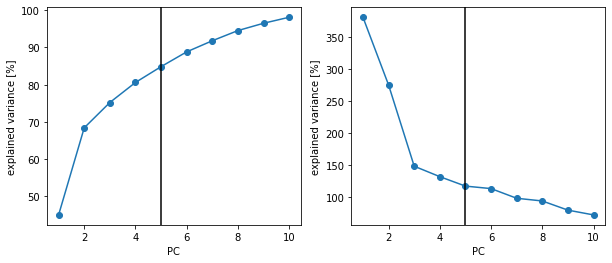

In [31]:
explained_var = pca_all.explained_variance_ratio_
singular_vals = pca_all.singular_values_
X = np.arange(1, 11)

fig, axes = plt.subplots(1,2,figsize=(10,4))

ax = axes[0]
ax.plot(X, np.cumsum(explained_var)*100, 'o-')
ax.axvline(5, c='k')
ax.set_ylabel('explained variance [%]')
ax.set_xlabel('PC')

ax = axes[1]
ax.plot(X, singular_vals, 'o-')
ax.axvline(5, c='k')
ax.set_ylabel('explained variance [%]')
ax.set_xlabel('PC')

In [32]:
np.cumsum(explained_var)*100

array([44.9415489 , 68.37908008, 75.19194435, 80.5867668 , 84.8442245 ,
       88.82346756, 91.81276793, 94.55167516, 96.51914531, 98.13597308])

## 3.4 Check which marks corralte with PCs

In [33]:
NPC = 5

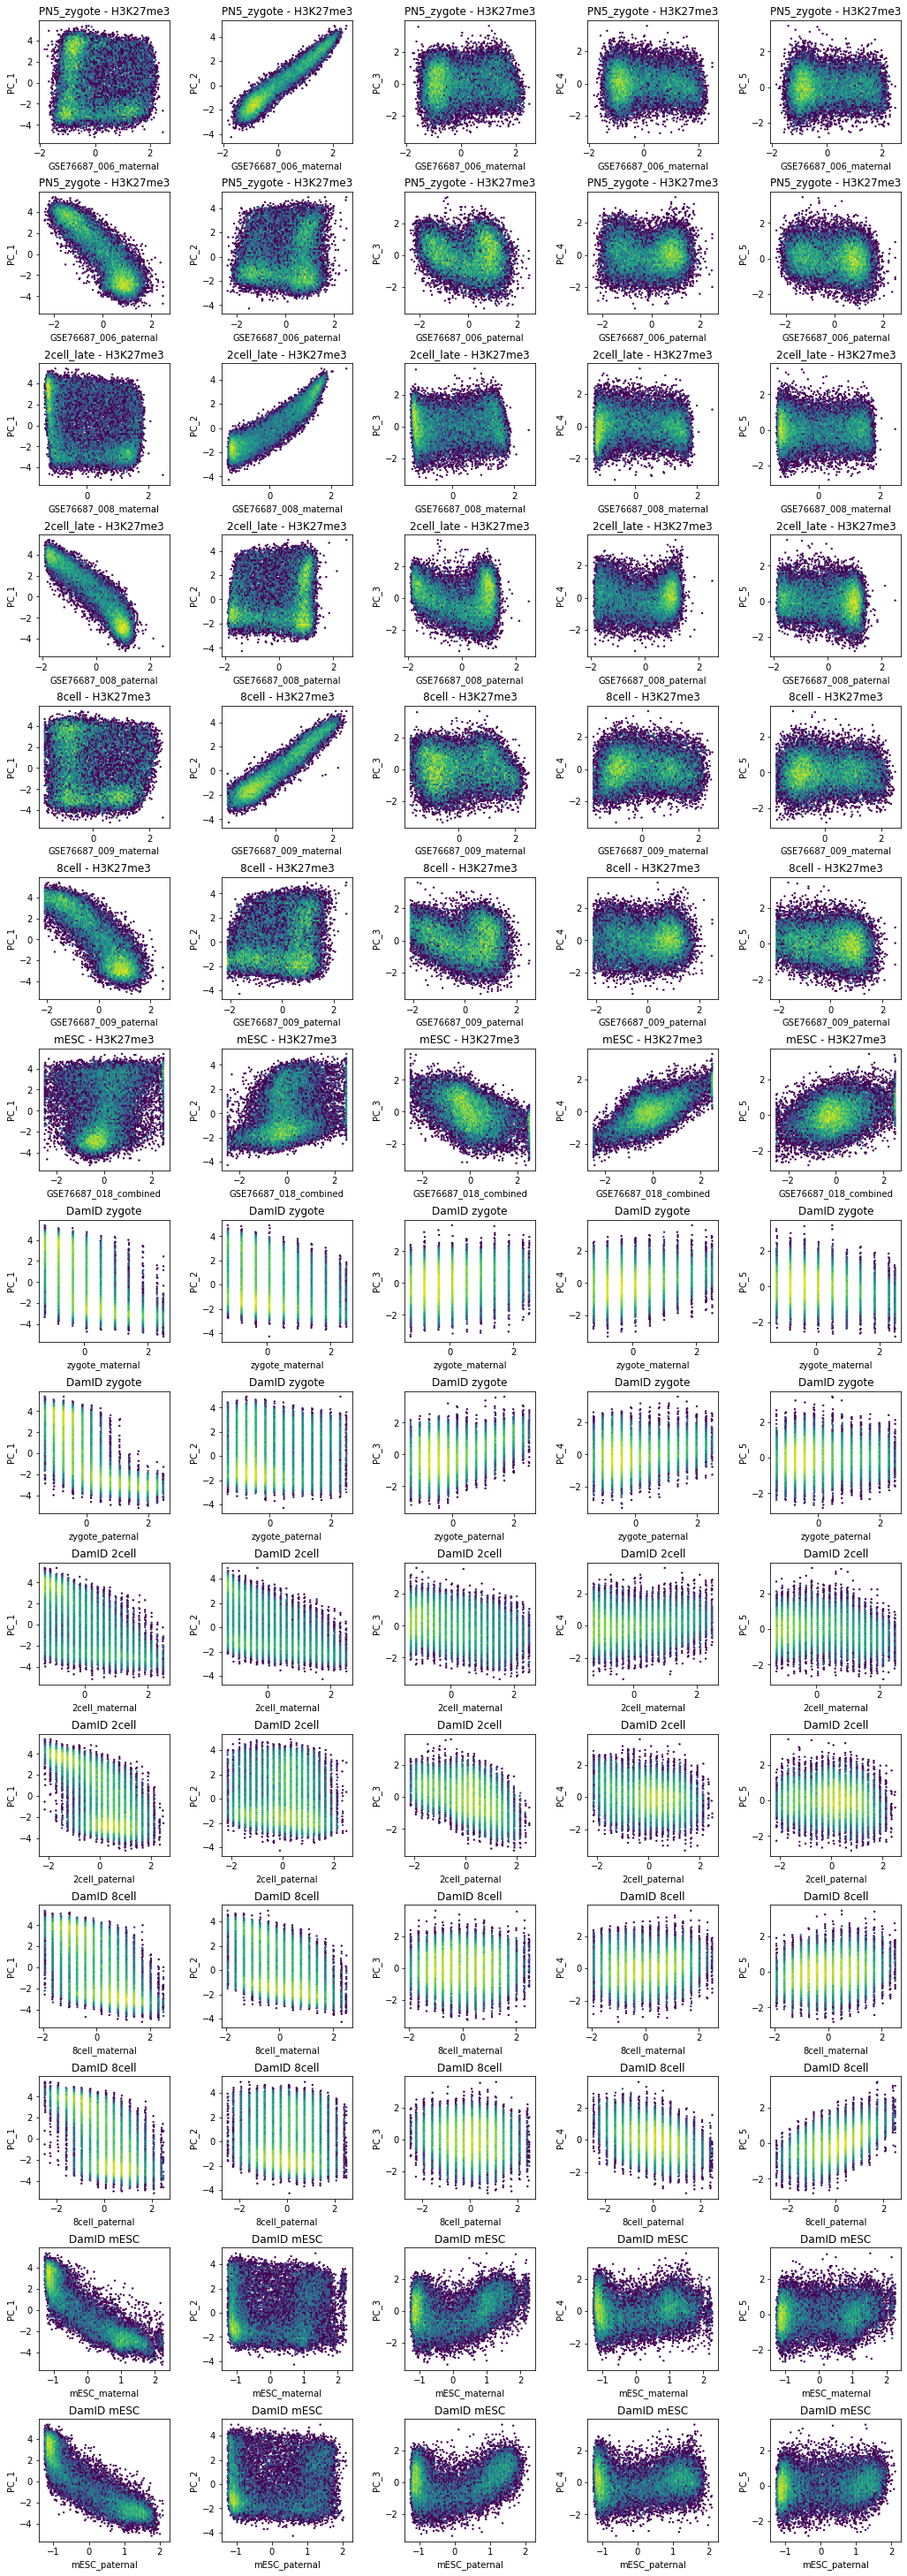

In [35]:
ncol = NPC
nrow = cluster_data.shape[1]

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3.5, nrow*3.5))
plt.subplots_adjust(hspace=.4, wspace=.4)

for irow, col in enumerate(cluster_data.columns):
    for ipc in np.arange(NPC):
        ax = axes[irow, ipc]
        pcname = 'PC_%d' % (ipc+1)
        
        X = cluster_data[col].values
        Y = data_transform[:,ipc]
        ax.hexbin(X, Y, bins='log')
        
        ax.set_ylabel(pcname)
        ax.set_xlabel(col)
        
        if col.split('_')[0] not in ['zygote', '2cell', '8cell', 'mESC']:
            s = '_'.join(col.split('_')[:-1])
            a = ext_cluster_anno.loc[ext_cluster_anno.sample_id==s, 'stage'].values[0]
            b = ext_cluster_anno.loc[ext_cluster_anno.sample_id==s, 'target'].values[0]
            T = '%s - %s' % (a, b)
        else:
            T = 'DamID %s' % col.split('_')[0]
        ax.set_title(T)

## 3.5 Compute UMAP

In [36]:
from umap import UMAP

In [37]:
data_embedded = UMAP(random_state=1).fit_transform(data_transform[:,:NPC])

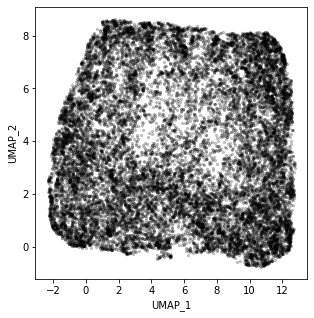

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(data_embedded[:,0], data_embedded[:,1], alpha=.2, c='k', s=5)
ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
ax.set_box_aspect(1)

outfn = FIGOUTDIR + 'bin_UMAP.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')
plt.savefig(outfn.replace('pdf', 'png'), bbox_inches='tight')

## 3.6 Show UMAP - standardized data

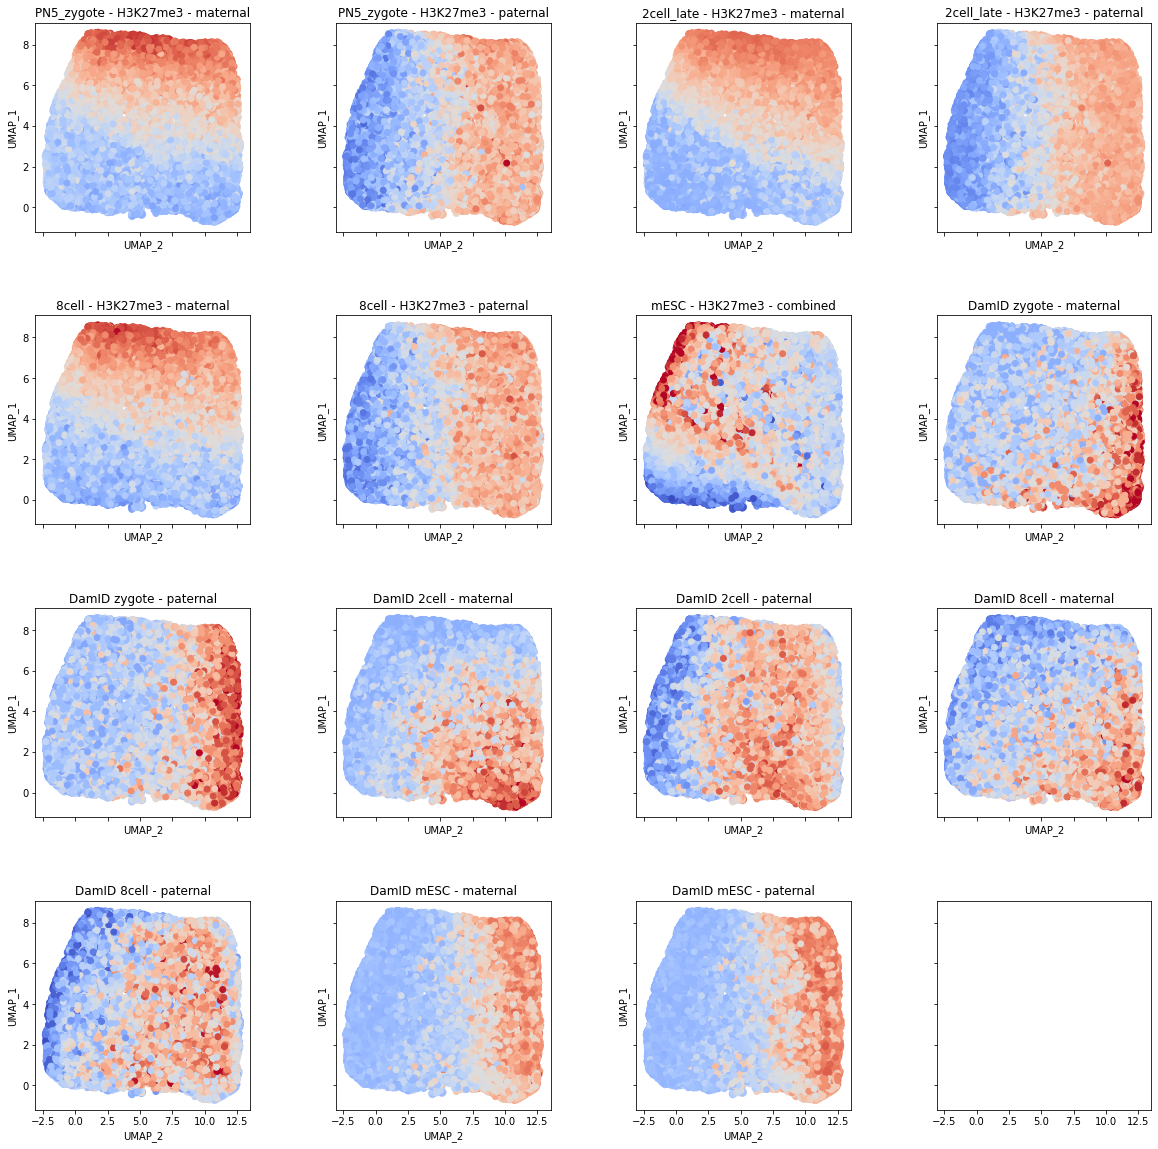

In [39]:
ncol = 4
nplot = cluster_data.shape[1]
nrow = int(np.ceil(nplot/ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=.4, wspace=.4)

X = data_embedded[:,0]
Y = data_embedded[:,1]

for iplot, col in enumerate(cluster_data.columns):
    ax = axes.flatten()[iplot]

    C = cluster_data[col].values
    ax.scatter(X, Y, c=C, cmap='coolwarm', vmin=-2.5, vmax=2.5)

    ax.set_ylabel('UMAP_1')
    ax.set_xlabel('UMAP_2')

    if col.split('_')[0] not in ['zygote', '2cell', '8cell', 'mESC']:
        s = '_'.join(col.split('_')[:-1])
        a = ext_cluster_anno.loc[ext_cluster_anno.sample_id==s, 'stage'].values[0]
        b = ext_cluster_anno.loc[ext_cluster_anno.sample_id==s, 'target'].values[0]
        T = '%s - %s - %s' % (a, b, col.split('_')[-1])
    else:
        T = 'DamID %s - %s' % (col.split('_')[0], col.split('_')[-1])
    ax.set_title(T)

## 3.6 Show UMAP - non-standardized data

In [40]:
dark_hexcode = {
    'H3K27me3': '#4f4163',
    'H3K9me3': '#a76427', #'#701320',
    'H3K4me3': '#375c2d',
    'H2AK119ub1': '#363738',
    'accessibility': '#365e80',
    'Lmnb1': '#540f1b' #'#aa852e'
}

In [41]:
import matplotlib

def make_cmap(cvals, colors=['cyan', 'black', 'yellow']):
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    return new_cmap

In [43]:
r_counter

0

In [44]:
c_counter

3

In [46]:
allele

'combined'

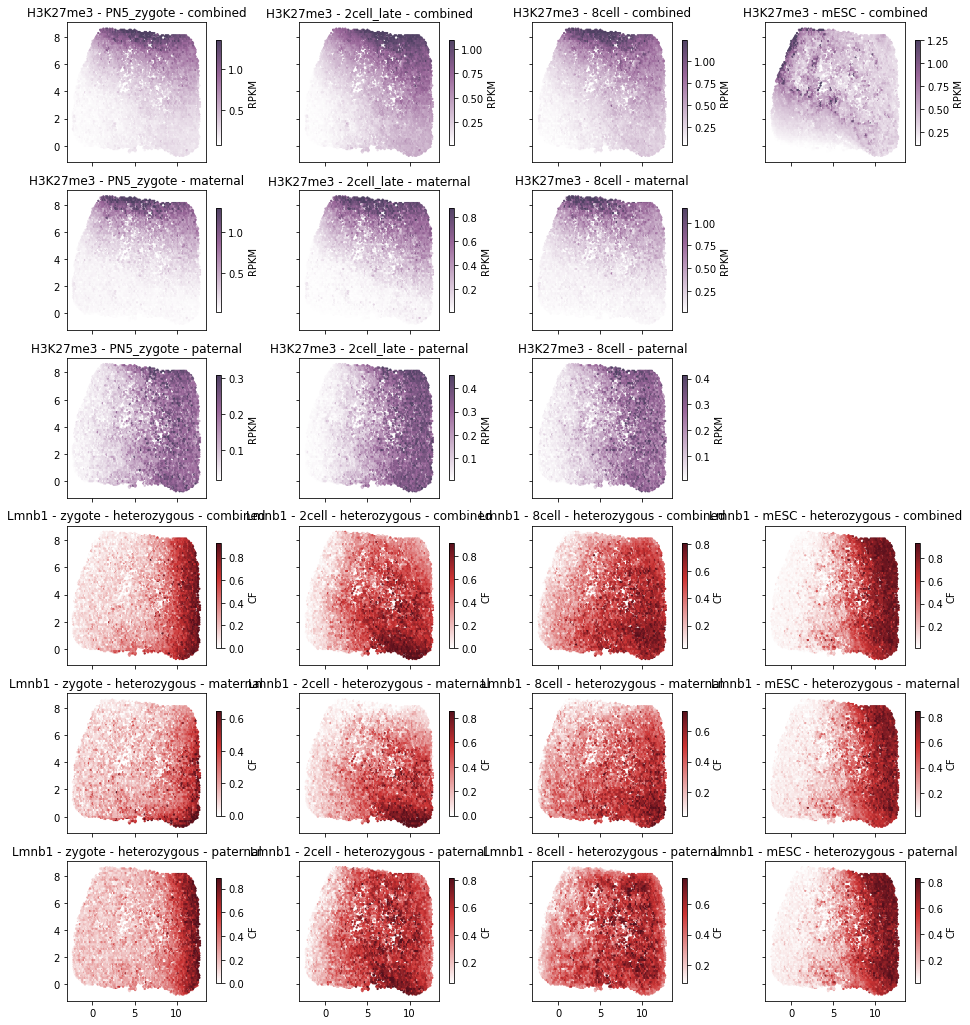

In [47]:
nrow = 3 * len(cluster_anno.target.unique())
ncol = 4

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3), sharex=True, sharey=True)
r_counter = 0

# select relevant external data
to_plot = ext_anno[ext_anno.sample_id.isin(ext_cluster_samples)].copy().sort_values(by=['target', 'stage'])

# select relevant UMAP coordinates
X = data_embedded[:,0]
Y = data_embedded[:,1]

for target, df in to_plot.groupby('target'):
    for allele in ['combined', 'maternal', 'paternal']:
        c_counter = 0
        
        for _, row in df.iterrows():
            ax = axes[r_counter, c_counter]
            c_counter += 1
            
            if (not row['is_heterozygous']) and (allele != 'combined'):
                ax.remove()
                continue
                
            # select data
            C = np.concatenate([ext_data[allele][row['sample_id']][c][cluster_filt_ind[c]] for c in cluster_chroms])
            
            # normalize data if input control is available
            if row['control_id'] != 'none':
                ctrl = np.concatenate([ext_data[allele][row['control_id']][c][cluster_filt_ind[c]] for c in cluster_chroms])
                C = np.log2( (C + 0.1) / (ctrl + 0.1) )
                ylab = 'log2OE'
            else:
                ylab = 'RPKM'
                
            # plot results
            p = ax.hexbin(X, Y, C=C)
            clim = np.percentile(p.get_array(), [1,99])
            
            # select / generate cmap 
            if (target in color_dict['target']):
                if ylab == 'log2OE':
                    m = max(clim)
                    clim = [-m, m]
                    cmap = make_cmap(
                        [-m, 0, 0.5*m, m], 
                        colors=['grey', 'white', color_dict['target'][target], dark_hexcode[target]]
                    )
                else:
                    r = clim[1] - clim[0]
                    cmap = make_cmap(
                        [clim[0], clim[0]+0.66*r, clim[1]], 
                        colors=['white', color_dict['target'][target], dark_hexcode[target]]
                    )
            else:
                
                if ylab == 'log2OE':
                    m = max(clim)
                    clim = [-m, m]
                    cmap = 'RdBu_r'
                else:
                    cmap = 'bone_r'
            
            p.remove()
            p = ax.hexbin(X, Y, C=C, cmap=cmap, vmin=clim[0], vmax=clim[1])
            cbar = plt.colorbar(p, ax=ax, shrink=0.75)
            cbar.ax.set_ylabel(ylab)
                
            # format
            title = '%s - %s - %s' % (row['target'], row['stage'], allele)
            ax.set_title(title)
            ax.set_box_aspect(1)
        
        r_counter += 1
        
for allele in ['combined', 'maternal', 'paternal']:
    c_counter = 0

    for _, row in anno_damid_cluster.iterrows():
        ax = axes[r_counter, c_counter]
        c_counter += 1
        
        # select data
        sample = (row['stage'], row['genotype'], row['treatment'])
        C = np.concatenate([contact_freq[allele][sample][c][cluster_filt_ind[c]] for c in cluster_chroms])
        
        # plot results
        p = ax.hexbin(X, Y, C=C)
        clim = np.percentile(p.get_array(), [1,99])
        
        # select / generate cmap 
        r = clim[1] - clim[0]
        cmap = make_cmap(
            [clim[0], clim[0]+0.66*r, clim[1]], 
            colors=['white', color_dict['target']['Lmnb1'], dark_hexcode['Lmnb1']]
        )

        p.remove()
        p = ax.hexbin(X, Y, C=C, cmap=cmap, vmin=clim[0], vmax=clim[1])
        cbar = plt.colorbar(p, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('CF')

        # format
        title = 'Lmnb1 - %s - heterozygous - %s' % (row['stage'], allele)
        ax.set_title(title)
        ax.set_box_aspect(1)

    r_counter += 1
    
outfn = FIGOUTDIR + 'bin_UMAP.colored_by_marks_used_in_clustering.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')
plt.savefig(outfn.replace('pdf', 'png'), bbox_inches='tight')

# 4. K-means clustering on PCs

The UMAP did not offer much insight into the number of clusters that should be chosen. Some trial and error led me to choose 8.

## 4.0 Determine optimal number of clusters

In [59]:
# from sklearn import cluster as skcluster
from sklearn import metrics as skmetrics
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform, pdist

In [60]:
from sklearn.cluster import KMeans

In [61]:
data = np.copy(data_transform[:,:NPC])
DF_dist = pdist(data, metric='euclidean')
DF_dist = squareform(DF_dist)

In [62]:
DF_dist.shape

(21712, 21712)

In [63]:
labels = dict()
silhouette = dict()
sumofsquares = dict()
for n in tqdm(range(2,11)):
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(data)
    labels[n] = kmeans.predict(data)
    silhouette[n] = skmetrics.silhouette_score(DF_dist, labels[n], metric="precomputed")
    
    sos = 0
    for l in set(labels[n]):
        ind = labels[n] == l
        d = sp.distance.pdist(data[ind], metric='euclidean')
        sos += (d**2).sum()
    sumofsquares[n] = sos

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

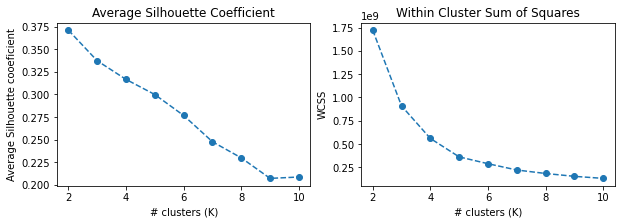

In [64]:
fig, axes = plt.subplots(1,2,figsize=(10,3))

ax = axes[0]
X = list(silhouette.keys())
Y = list(silhouette.values())
ax.plot(X, Y, 'o--')
ax.set_ylabel('Average Silhouette cooeficient')
ax.set_xlabel('# clusters (K)')
ax.set_title('Average Silhouette Coefficient')

ax = axes[1]
X = list(sumofsquares.keys())
Y = list(sumofsquares.values())
ax.plot(X, Y, 'o--')
ax.set_ylabel('WCSS')
ax.set_xlabel('# clusters (K)')
ax.set_title('Within Cluster Sum of Squares')

plt.show()

## 4.1 Perform K-means cllustering

In [86]:
np.random.seed(1)
kclusters = KMeans(n_clusters=6).fit_predict(data_transform[:,:NPC])

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


__Improve order of clusters__

In [87]:
# determine best order of clusteres
df = pd.DataFrame(data_transform[:,:NPC]).copy()
# df = cluster_data[['zygote_maternal', 'zygote_paternal', '2cell_maternal', '2cell_paternal', 'mESC_maternal', 'mESC_paternal']].copy()
df['K'] = kclusters
df = df.groupby('K').mean()

dist = pdist(df.values)
linkage = hc.linkage(dist, method='average')
order = hc.leaves_list(linkage)

tmp = {k_prev: k_new for k_new, k_prev in enumerate(df.index.values[order])}
kclusters = np.array([tmp[k] for k in kclusters])

## 4.2 Visualize standardized data used for clustering 

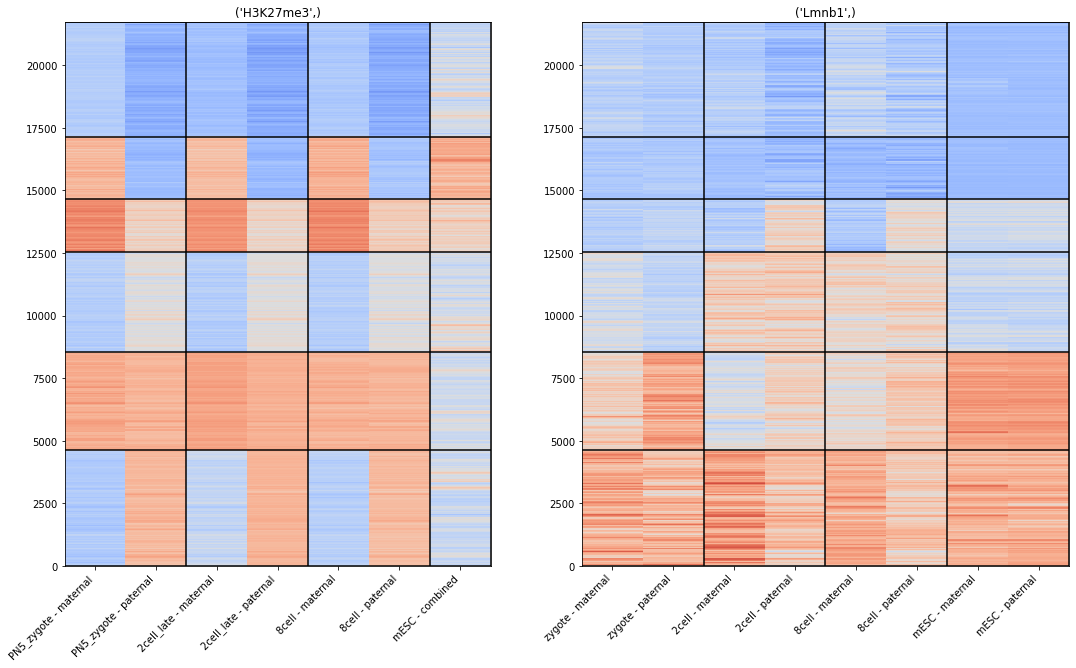

In [90]:
# prepar figure layout
g_to_plot = cluster_anno.groupby(['target'])
ncol = len(list(g_to_plot))
wr = [len(df) for _, df in g_to_plot]

fig, axes = plt.subplots(1, ncol, figsize=(18, 10), gridspec_kw={'width_ratios': wr})
counter = 0

# determine ordering of clusters
order = np.argsort(kclusters)
n_per_k = np.array([(kclusters==k).sum() for k in range(kclusters.max()+1)])
yseps = np.cumsum(n_per_k)

for target, df in g_to_plot:
    ax = axes[counter]
    counter += 1
    
    df = df.copy().sort_values(by=['stage', 'parent'])
    
    
    xticklabs = list()
    x = 0
    for _, row in df.iterrows():

        C = cluster_data[row['name']].values[order]
        C = np.atleast_2d(C).T
        ax.imshow(C, extent=[x, x+1, 0, C.shape[0]], origin='lower', aspect='auto', cmap='coolwarm', vmin=-2.5, vmax=2.5)

        t = '%s - %s' % (row['stage'], row['parent'])
        xticklabs.append(t)
        
        if row['parent'] != 'maternal':
            ax.axvline(x+1, c='k')
        x += 1

    ax.set_title(target)
    ax.set_xticks(np.arange(x)+.5)
    ax.set_xticklabels(xticklabs, rotation=45, ha='right')
    ax.set_xlim(0, x)
    ax.set_ylim(0, C.shape[0])

    for y in yseps:
        ax.axhline(y, c='k')

## 4.3 Set cluster ordering manually

In [89]:
tmp = {
    0: 4,
    1: 5,
    2: 0,
    3: 2,
    4: 1,
    5: 3
}

kclusters = np.array([tmp[k]+1 for k in kclusters])

## 4.4 Visualize K-means clusters on UMAP

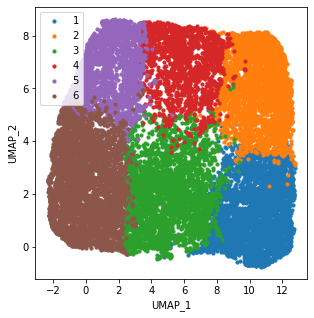

In [91]:
to_plot = pd.DataFrame(data_embedded, columns=['UMAP_1', 'UMAP_2'])
to_plot['K'] = kclusters

fig, ax = plt.subplots(figsize=(5,5))

for k, df in to_plot.groupby('K'):

    ax.scatter(df['UMAP_1'], df['UMAP_2'], label=k, s=10)
    
ax.legend()
ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
ax.set_box_aspect(1)

outfn = FIGOUTDIR + 'bin_UMAP.colored_by_K_clustering.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')
plt.savefig(outfn.replace('pdf', 'png'), bbox_inches='tight')

## 4.5 Save clustering

In [92]:
chrom_ident = np.concatenate([np.repeat(c, len(mapab[c]))[cluster_filt_ind[c]] for c in cluster_chroms])
bin_ident = np.concatenate([np.arange(0, len(mapab[c]))[cluster_filt_ind[c]] for c in cluster_chroms])
kcluster_df = pd.DataFrame({
    'chrom': chrom_ident,
    'bin_ind': bin_ident,
    'Kcluster': kclusters
})
kcluster_df['start'] = kcluster_df['bin_ind'] * BINSIZE
kcluster_df['end'] = kcluster_df['start'] + BINSIZE
kcluster_df = kcluster_df[['chrom', 'start', 'end', 'bin_ind', 'Kcluster']]

In [93]:
kcluster_df.head()

chrom    start      end  bin_ind  Kcluster
0     1  3000000  3100000       30         4
1     1  3100000  3200000       31         2
2     1  3200000  3300000       32         2
3     1  3300000  3400000       33         1
4     1  3400000  3500000       34         1

In [94]:
outfn = FIGOUTDIR + 'FR231103.clustering_of_bins.binsize_%d.tsv' % BINSIZE
kcluster_df.to_csv(outfn, sep='\t', header=True, index=False)

## 4.5 Visualize number of bins per cluster

(21712, 3)
(24618, 2)


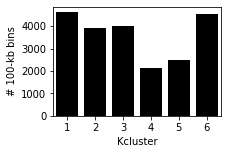

In [95]:
to_plot = kcluster_df[['chrom', 'bin_ind', 'Kcluster']].copy()
to_plot['Kcluster'] = to_plot['Kcluster'].values.astype(str)
print(to_plot.shape)

# add filtered out bins
chrom_ident = np.concatenate([np.repeat(c, len(mapab[c])) for c in cluster_chroms])
bin_ident = np.concatenate([np.arange(0, len(mapab[c])) for c in cluster_chroms])
tmp = pd.DataFrame({
    'chrom': chrom_ident,
    'bin_ind': bin_ident,
})
print(tmp.shape)

# to_plot = to_plot.merge(tmp, how='outer')
# to_plot['Kcluster'] = to_plot['Kcluster'].fillna('filtered')

df = to_plot.groupby('Kcluster').size().reset_index().rename(columns={0: 'n'})
fig, ax = plt.subplots(figsize=(3,2))
sns.barplot(x=df['Kcluster'], y=df['n'], color='k', ax=ax)
ax.set_ylabel('# %d-kb bins' % int(BINSIZE/1000))

outfn = FIGOUTDIR + 'number_of_bins_per_cluster.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

outfn = FIGOUTDIR + 'number_of_bins_per_cluster.binsize_%d.tsv' % BINSIZE
df.to_csv(outfn, sep='\t', header=True, index=False)

## 4.6 Save K-means clusters as a bed track

In [96]:
from itertools import groupby

In [97]:
alldfs = list()

for chrom in chrom_order:

    if chrom not in kcluster_df.chrom.values:
        continue
        
    df = kcluster_df[kcluster_df.chrom==chrom].copy()
    template = pd.DataFrame({'chrom': np.repeat(chrom, df['bin_ind'].max()+1), 'bin_ind': np.arange(0, df['bin_ind'].max()+1)})
    df = template.merge(df, how='outer').sort_values(by=['chrom', 'bin_ind']).reset_index(drop=True)
    df['Kcluster'] = df['Kcluster'].fillna(-1)
    df['Kcluster'] = df['Kcluster'].apply(func = lambda k: 'NA' if k == -1 else 'K%.0f' % k)
    gr = groupby(df.Kcluster)

    sumls = list()
    start = 0
    for clus, vals in gr:
        nbins = len(list(vals))
        row = [chrom, clus, start, start + nbins]
        sumls.append(row)
        start += nbins

    sumdf = pd.DataFrame(sumls, columns=['chrom', 'cluster', 'start_bin', 'end_bin']) 
    sumdf['start'] = sumdf['start_bin'] * BINSIZE
    sumdf['end'] = sumdf['end_bin'] * BINSIZE
    
    alldfs.append(sumdf[['chrom', 'start', 'end', 'cluster']])

kcluster_bed = pd.concat(alldfs, axis=0)

In [98]:
from matplotlib import colors

In [99]:
#further format
kcluster_bed['score'] = 1
kcluster_bed['strand'] = '.'
kcluster_bed['thickStart'] = kcluster_bed['start']
kcluster_bed['thickEnd'] = kcluster_bed['end']
kcluster_bed = kcluster_bed[kcluster_bed['cluster'] != 'NA']

# make colorscheme
validk = kcluster_bed['cluster'].sort_values().unique()
clrdict = {k: sns.color_palette('tab10', n_colors=10)[i] for i, k in enumerate(validk)}
clrdict_format = {k: '%d,%d,%d' % (v[0]*255, v[1]*255, v[2]*255) for k, v in clrdict.items()}
kcluster_bed['itemRgb'] = kcluster_bed['cluster'].apply(func = lambda c: clrdict_format[c]).values


headerline = 'track name=\"Bin clusters\" itemRgb=\"On\"\n'
OUTFN = FIGOUTDIR + 'FR231103.clustering_of_bins.binsize_%d.track.bed' % BINSIZE
with open(OUTFN, 'w') as f:
    f.write(headerline)
kcluster_bed.to_csv(OUTFN, header=False, index=False, sep='\t', mode='a')

In [100]:
kcluster_bed.head()

chrom    start      end cluster  score strand  thickStart  thickEnd  \
1     1  3000000  3100000      K4      1      .     3000000   3100000   
2     1  3100000  3300000      K2      1      .     3100000   3300000   
3     1  3300000  4400000      K1      1      .     3300000   4400000   
4     1  4400000  4500000      K3      1      .     4400000   4500000   
5     1  4500000  4700000      K4      1      .     4500000   4700000   

      itemRgb  
1   214,39,40  
2  255,127,14  
3  31,119,180  
4   44,160,44  
5   214,39,40